In [21]:
import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 

import numpy as np
import matplotlib.pyplot as plt
import torch
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

from astropy.cosmology import Planck18
from astropy.cosmology import FLRW, w0wzCDM
from astropy import constants

from scipy.interpolate import interp1d
import time 

torch.set_default_dtype(torch.float64)

In [11]:
np_dtype = np.float64
redshifts = np.round(np.arange(0.05, 3.551, 0.001, dtype=np_dtype), 2)
designs = torch.tensor(redshifts).to(device)

In [12]:
# hubble distance measurements
y_h1 = 19.77
sig_h1 = 0.47
y_h2 = 8.99
sig_h2 = 0.17

# angular diameter distance measurements
y_a1 = 17.65
sig_a1 = 0.30
y_a2 = 37.5
sig_a2 = 1.1

# redshift observation points
z_1 = 0.698 # LRGs
z_2 = 2.33 # Lyman-alpha
c = constants.c.to('km/s').value
r_drag = 147.55

cosmo = w0wzCDM(H0=Planck18.H0, Om0=Planck18.Om0, Tcmb0=Planck18.Tcmb0, Ode0=Planck18.Ode0, w0=-1, wz=0)
print("Energy density of matter today: ", cosmo.Om0)
print("Energy density of dark energy today: ", cosmo.Ode0)
print("Hubble constant today: ", cosmo.H0)
print("Energy density of radiation today: ", cosmo.Ogamma0 + cosmo.Onu0)
print("Curvature of universe today: ", cosmo.Ok0)
Om = cosmo.Om0
Ode = cosmo.Ode0
H0 = cosmo.H0.value
Orad = cosmo.Ogamma0 + cosmo.Onu0
Ok = cosmo.Ok0

coeff = c/(H0*r_drag)

Energy density of matter today:  0.30966
Energy density of dark energy today:  0.6888463055445441
Hubble constant today:  67.66 km / (Mpc s)
Energy density of radiation today:  9.131600127112836e-05
Curvature of universe today:  0.0014023784541847566


In [9]:
def D_H_astro(z, omm=Planck18.Om0, w0=-1, r_drag=147.55):
    if type(omm) == torch.Tensor:
        flat_omm = omm.flatten()
        flat_z = z.flatten()
        y = []
        for i in range(len(flat_omm)):
            cosmology = w0wzCDM(H0=Planck18.H0, Om0=flat_omm[i], Ode0=Planck18.Ode0, w0=w0, wz=0.0)
            if len(flat_z) > 1:
                y.append((c/cosmology.H(flat_z[i].cpu().numpy())).value/r_drag)
            else:
                y.append((c/cosmology.H(z.cpu().numpy())).value/r_drag)
        y = torch.tensor(np.array(y), device=device)
        return y.view(omm.shape)
    else:
        cosmology = w0wzCDM(H0=Planck18.H0, Om0=omm, Ode0=Planck18.Ode0, w0=w0, wz=0.0)
        return torch.tensor((c/cosmology.H(z.cpu().numpy())).value/r_drag, device=device)

def D_H_func(z, om_m=Planck18.Om0):
    return (coeff/torch.sqrt(om_m*(1+z)**3+(1-om_m))).to(device)

def D_A_func(z, om=Planck18.Om0, w0=-1, r_drag=147.55):
    cosmology = w0wzCDM(H0=Planck18.H0, Om0=om, Ode0=Planck18.Ode0, w0=w0, wz=0.0)
    return torch.tensor(cosmology.comoving_transverse_distance(z.cpu().numpy()).value/r_drag, device=device)

In [11]:
bgs_redshifts = torch.tensor([0.05, 0.15, 0.25, 0.35, 0.45]) # redshifts from Bright Galaxy Survey
lrg_redshifts = torch.arange(0.65, 1.95, 0.1) # redshifts from Luminous Red Galaxies
lyman_alp_redshifts = torch.tensor([1.96, 2.12, 2.28, 2.43, 2.59, 2.75, 2.91, 3.07, 3.23, 3.39, 3.55]) # redshifts from Lyman Alpha
error_redshifts = torch.cat([bgs_redshifts, lrg_redshifts, lyman_alp_redshifts])
DH_errors = torch.tensor([12.10, 4.66, 2.97, 2.44, 3.69, 1.50, 1.27, 1.22, 1.22, 1.37, 1.39, 1.39, 2.02, 2.13, 2.52, 3.80, 6.30, 6.39, 2.74, 1.99, 2.11, 2.26, 2.47, 2.76, 3.18, 3.70, 4.57, 6.19, 8.89], device=device)/100
DM_errors = torch.tensor([6.12, 2.35, 1.51, 1.32, 2.39, 0.82, 0.69, 0.69, 0.73, 0.89, 0.94, 0.96, 1.50, 1.59, 1.90, 2.88, 4.64, 4.71, 2.69, 1.95, 2.18, 2.46, 2.86, 3.40, 4.21, 5.29, 7.10, 10.46, 15.91], device=device)/100

errors = pd.DataFrame({'z': error_redshifts.cpu().numpy(), 'DH_errors': DH_errors.cpu().numpy(), 'DM_errors': DM_errors.cpu().numpy()})

errors.to_csv('/global/homes/a/ashandon/data/variable_error.csv')

In [43]:
errors

,z,DH_errors,DM_errors
0,0.05,0.1210,0.0612
1,0.15,0.0466,0.0235
2,0.25,0.0297,0.0151
3,0.35,0.0244,0.0132
4,0.45,0.0369,0.0239
5,0.65,0.0150,0.0082
6,0.75,0.0127,0.0069
7,0.85,0.0122,0.0069
8,0.95,0.0122,0.0073
9,1.05,0.0137,0.0089


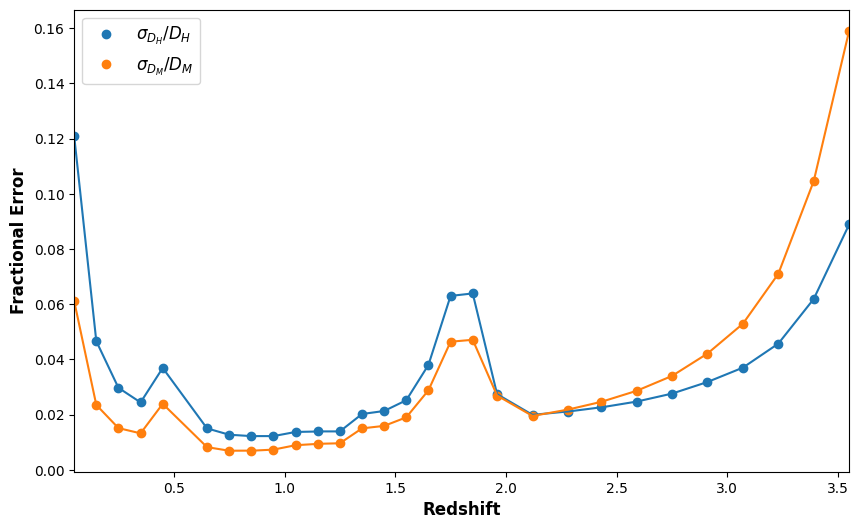

In [57]:
D_H_error_func = interp1d(errors['z'], errors['DH_errors'], kind='linear', fill_value='extrapolate')
D_M_error_func = interp1d(errors['z'], errors['DM_errors'], kind='linear', fill_value='extrapolate')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(errors['z'], errors['DH_errors'], 'o', label='$\sigma_{D_H}/D_H$', color='tab:blue')
ax.plot(errors['z'], errors['DM_errors'], 'o', label='$\sigma_{D_M}/D_M$', color='tab:orange')

redshifts = np.linspace(0.05, 3.55, int(round((3.55 - 0.05) / 0.01)) + 1)
designs = torch.tensor(redshifts).to(device)

'''
region_specs = [
    ("BGS", 0.05, 0.5, "#8ecaff"),
    ("LRG", 0.5, 1.1, "#ff9f6e"),
    ("ELG", 0.8, 1.6, "#c38bff"),
    ("QSOs", 0.8, 2.1, "#6ed8a0"),
    ("Lyman-Alpha", 1.95, 3.55, "#ffdd5c"),
]
for label, start, end, color in region_specs:
    ax.axvspan(start, end, color=color, alpha=0.35, edgecolor='none', zorder=0)
'''
ax.plot(designs.cpu().numpy(), D_H_error_func(designs.cpu().numpy()), color='tab:blue')
ax.plot(designs.cpu().numpy(), D_M_error_func(designs.cpu().numpy()), color='tab:orange')
ax.set_xlabel('Redshift', fontsize=12, weight='bold')
ax.set_ylabel('Fractional Error', fontsize=12, weight='bold')
ax.set_xlim(0.05, 3.55)
handles, labels = ax.get_legend_handles_labels()
seen = {}
filtered_handles = []
filtered_labels = []
for handle, label in zip(handles, labels):
    if label not in seen:
        seen[label] = True
        filtered_handles.append(handle)
        filtered_labels.append(label)
ax.legend(filtered_handles, filtered_labels, fontsize=12, loc='upper left')
plt.show()

In [12]:
errors

,z,DH_errors,DM_errors
0,0.05,0.1210,0.0612
1,0.15,0.0466,0.0235
2,0.25,0.0297,0.0151
3,0.35,0.0244,0.0132
4,0.45,0.0369,0.0239
5,0.65,0.0150,0.0082
6,0.75,0.0127,0.0069
7,0.85,0.0122,0.0069
8,0.95,0.0122,0.0073
9,1.05,0.0137,0.0089


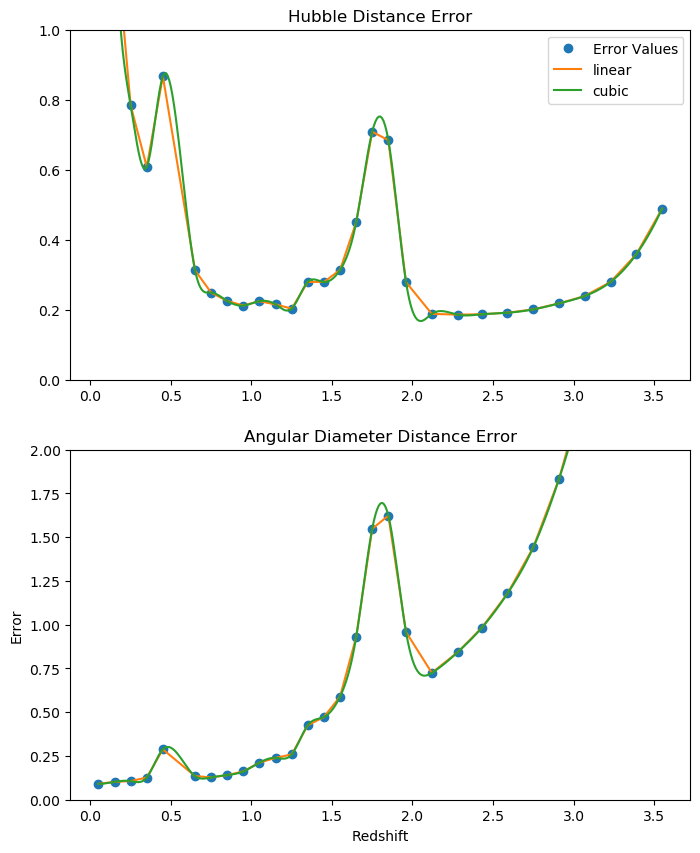

In [19]:
bgs_redshifts = torch.tensor([0.05, 0.15, 0.25, 0.35, 0.45]) # redshifts from Bright Galaxy Survey
lrg_redshifts = torch.arange(0.65, 1.95, 0.1) # redshifts from Luminous Red Galaxies
lyman_alp_redshifts = torch.tensor([1.96, 2.12, 2.28, 2.43, 2.59, 2.75, 2.91, 3.07, 3.23, 3.39, 3.55]) # redshifts from Lyman Alpha
error_redshifts = torch.cat([bgs_redshifts, lrg_redshifts, lyman_alp_redshifts])
H_errors = torch.tensor([12.10, 4.66, 2.97, 2.44, 3.69, 1.50, 1.27, 1.22, 1.22, 1.37, 1.39, 1.39, 2.02, 2.13, 2.52, 3.80, 6.30, 6.39, 2.74, 1.99, 2.11, 2.26, 2.47, 2.76, 3.18, 3.70, 4.57, 6.19, 8.89], device=device)/100
D_A_errors = torch.tensor([6.12, 2.35, 1.51, 1.32, 2.39, 0.82, 0.69, 0.69, 0.73, 0.89, 0.94, 0.96, 1.50, 1.59, 1.90, 2.88, 4.64, 4.71, 2.69, 1.95, 2.18, 2.46, 2.86, 3.40, 4.21, 5.29, 7.10, 10.46, 15.91], device=device)/100
D_H = D_H_func(error_redshifts)
D_A = D_A_func(error_redshifts)
D_H_error = H_errors*D_H
D_A_error = D_A_errors*D_A

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 10))
ax0.plot(error_redshifts, D_H_error.cpu().numpy(), 'o', label='Error Values')
ax1.plot(error_redshifts, D_A_error.cpu().numpy(), 'o', label='Error Values')
for x in ["linear", "cubic"]:
    D_H_error_func = interp1d(error_redshifts, D_H_error.cpu().numpy(), kind=x)
    D_A_error_func = interp1d(error_redshifts, D_A_error.cpu().numpy(), kind=x)
    ax0.plot(designs.cpu().numpy(), D_H_error_func(designs.cpu().numpy()), label=x)
    ax1.plot(designs.cpu().numpy(), D_A_error_func(designs.cpu().numpy()), label=x)
ax0.set_title("Hubble Distance Error")
ax1.set_title("Angular Diameter Distance Error")
ax0.set_ylim(0, 1.0)
ax1.set_ylim(0, 2.0)
plt.ylabel("Error")
plt.xlabel("Redshift")
ax0.legend()
plt.show()

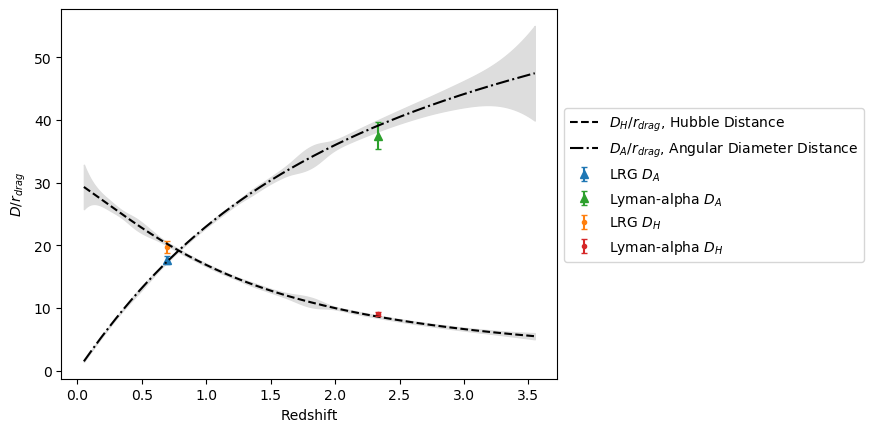

In [15]:
D_H_errors = D_H_error_func(designs.cpu().numpy())
D_A_errors = D_A_error_func(designs.cpu().numpy())
D_H = D_H_func(designs).cpu().numpy()
D_A = D_A_func(designs).cpu().numpy()

plt.figure()
plt.plot(designs.cpu().numpy(), D_H, label="$D_H/r_{drag}$, Hubble Distance", color="black", linestyle='--')
plt.plot(designs.cpu().numpy(), D_A, label="$D_A/r_{drag}$, Angular Diameter Distance", color="black", linestyle='-.')
plt.fill_between(designs.cpu().numpy(), D_H+D_H_errors, D_H-D_H_errors, alpha=1, color='#dddddd')
plt.fill_between(designs.cpu().numpy(), D_A+D_A_errors, D_A-D_A_errors, alpha=1, color='#dddddd')
plt.errorbar(z_1, y_a1, yerr=2*sig_a1, label='LRG $D_A$', barsabove=True, capsize=2, fmt='^', color='tab:blue')
plt.errorbar(z_2, y_a2, yerr=2*sig_a2, label='Lyman-alpha $D_A$', barsabove=True, capsize=2, fmt='^', color='tab:green')
plt.errorbar(z_1, y_h1, yerr=2*sig_h1, label='LRG $D_H$', barsabove=True, capsize=2, fmt='.', color='tab:orange')
plt.errorbar(z_2, y_h2, yerr=2*sig_h2, label='Lyman-alpha $D_H$', barsabove=True, capsize=2, fmt='.', color='tab:red')
plt.xlabel("Redshift")
plt.ylabel("$D/r_{drag}$")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.75))
plt.show()

In [16]:
class GP_Kernels:
    def __init__(self, se_sigma=0.05, se_l=10.0, poly_sigma=1.0, poly_degree=3):
        self.se_sigma = se_sigma
        self.se_l = se_l
        self.poly_sigma = poly_sigma
        self.poly_degree = poly_degree

    def se_kernel(self, a, b):
        # squared exponential kernel
        sqdist = torch.sum(a**2,axis=-1).unsqueeze(-1) + torch.sum(b**2,axis=-1).unsqueeze(-2) - 2*torch.matmul(a, b.transpose(-2,-1))
        return self.se_sigma**2*torch.exp(-(1/2) * (1/self.se_l**2) * sqdist)
    
    def poly_kernel(self, a, b):
        # polynomial kernel
        return (self.poly_sigma + torch.matmul(a, b.transpose(-2,-1)))**self.poly_degree

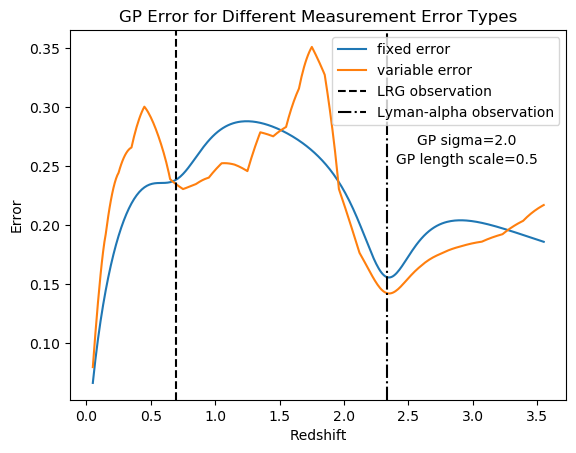

In [17]:
se_l = 0.5 # smoothness parameter
se_sigma = 2.0 # thickness parameter
poly_degree = 5.0 # degree of polynomial kernel
poly_sigma = 0.5 
kernels = GP_Kernels(se_sigma=se_sigma, se_l=se_l, poly_sigma=poly_sigma, poly_degree=poly_degree)
kernel = kernels.se_kernel

D_H_error_func = interp1d(error_redshifts, D_H_error.cpu().numpy(), kind='linear')

plt.figure()
for error_type in ["fixed", "variable"]:
    new_pt_error = []
    for i in designs:
        om = torch.tensor([0.315], device=device).reshape(-1, 1) # Gaussian prior mean
        sigma_prior = torch.tensor(0.02, device=device) # Gaussian prior std

        z_val = round(i.item(),2)
        new_z = torch.tensor(z_val, device=device)
        prev_z = torch.tensor([z_1, z_2], device=device)
        X = torch.concat((prev_z, new_z.unsqueeze(0)), dim=0)
        X = X.repeat(len(om), 1).unsqueeze(-1) # shape: (batch_size, 2)

        new_y = D_H_func(new_z, om)
        prev_y = torch.tensor([y_h1, y_h2], device=device).unsqueeze(-1)
        measured_y = torch.concat((prev_y, new_y), dim=0)
        zero_y = (2/(sigma_prior*((1+X.squeeze())**3-1)))*((measured_y*(om*(1+X.squeeze())**3+(1-om))**(3/2))/coeff-(om*(1+X.squeeze())**3+(1-om)))

        if error_type == "fixed":
            new_error = torch.tensor(0.3, device=device).unsqueeze(0)
        elif error_type == "variable":
            new_error = torch.tensor(D_H_error_func(z_val), device=device).unsqueeze(0)
        prev_error = torch.tensor([sig_h1, sig_h2], device=device)
        error = torch.concat((prev_error, new_error), dim=0)
        zero_error = (2*error*(om*(1+X.squeeze())**3+(1-om))**(3/2))/(coeff*(sigma_prior*((1+X.squeeze())**3-1))) # zero error

        K = kernel(X, X) # shape: (N, N)
        L = torch.linalg.cholesky(K + zero_error.unsqueeze(-1)*torch.eye(X.shape[1], device=device)) # add zeroed error, (line 1 of https://arxiv.org/pdf/2009.10862.pdf)

        # points we're going to make predictions at.
        X_test = torch.arange(0, 4, 0.01).to(device) # shape: (M,1), M = number of test points
        X_test = X_test.repeat(len(om), 1).unsqueeze(-1)

        # compute the mean at our test points.
        Lk = torch.linalg.solve(L, kernel(X, X_test))  # k_star = kernel(X, X_test), calculating v := l\k_star (line 4), shape: (batch_size, N, M)
        mu = torch.matmul(Lk.transpose(1,2), torch.linalg.solve(L, zero_y.unsqueeze(-1)))    # \alpha = np.linalg.solve(L, y), (lines 2 and 3), shape: (batch_size, M, 1)

        # compute the variance at our test points.
        K_ = kernel(X_test, X_test)        # k(x_star, x_star)
        s2 = torch.diagonal(K_, dim1=1, dim2=2) - torch.sum(Lk**2, axis=1) # s2 = k_star_star - np.einsum("ij,ij->j", v, v) (line 5), shape: (batch_size, M)
        s = torch.sqrt(s2)

        mean_pred = coeff*(mu.squeeze()*((sigma_prior*((1+X_test.squeeze())**3-1))/(2*(om*(1+X_test.squeeze())**3+(1-om))**(3/2))) + (om*(1+X_test.squeeze())**3+(1-om))**(-1/2))
        error_pred = (s*coeff*sigma_prior*((1+X_test.squeeze())**3-1))/(2*(om*(1+X_test.squeeze())**3+(1-om))**(3/2))

        # find the index of the new_zew
        new_pt_error.append(error_pred[:,X_test.cpu().squeeze().numpy().round(2).tolist().index(z_val)].item())


    plt.plot(designs.cpu().numpy(), new_pt_error, label="{} error".format(error_type))
plt.axvline(x=0.698, color='black', linestyle='--', label="LRG observation")
plt.axvline(x=2.330, color='black', linestyle='-.', label="Lyman-alpha observation")
plt.text(0.8, 0.7, "GP sigma={}".format(se_sigma), ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.8, 0.65, "GP length scale={}".format(se_l), ha='center', va='center', transform=plt.gca().transAxes)
plt.title("GP Error for Different Measurement Error Types")
# add text on white background at same relative position
plt.xlabel("Redshift")
plt.ylabel("Error")
plt.legend()
plt.show()